# **Laborator nr.1 Spark**

#### 1.1 Crearea unui program Spark în Python pentru prelucrarea unui set mare de date + importul setlui de date

In [1]:
import pyspark
from pyspark.sql import SparkSession

# Inițializează SparkSession și citește fișierul CSV în Spark DataFrame
spark = SparkSession.builder \
    .appName("Big Data Processing") \
    .getOrCreate()

# Citirea fișierului CSV în Spark DataFrame
df = spark.read.csv("cs_data.csv", header=True, inferSchema=True)

# Afișează primele 10 rânduri
df.show(10)


+----------+-----------+------+---+---------+--------+-------+--------------+------------+----------------+
|invoice_no|customer_id|gender|age| category|quantity|  price|payment_method|invoice_date|   shopping_mall|
+----------+-----------+------+---+---------+--------+-------+--------------+------------+----------------+
|   I138884|    C241288|Female| 28| Clothing|       5| 1500.4|   Credit Card|    5/8/2022|          Kanyon|
|   I317333|    C111565|  Male| 21|    Shoes|       3|1800.51|    Debit Card|  12/12/2021|  Forum Istanbul|
|   I127801|    C266599|  Male| 20| Clothing|       1| 300.08|          Cash|   9/11/2021|       Metrocity|
|   I173702|    C988172|Female| 66|    Shoes|       5|3000.85|   Credit Card|  16/05/2021|    Metropol AVM|
|   I337046|    C189076|Female| 53|    Books|       4|   60.6|          Cash|  24/10/2021|          Kanyon|
|   I227836|    C657758|Female| 28| Clothing|       5| 1500.4|   Credit Card|  24/05/2022|  Forum Istanbul|
|   I121056|    C151197|Fema

#### 1.2  Executarea operațiilor de transformare (ex.: map, filter, reduce). 

In [2]:
from pyspark.sql.functions import col, sum

# 1. Filtrare: Selectăm doar tranzacțiile plătite cu "Credit Card" și eliminăm valorile None
filtered_df = df.filter((col("payment_method") == "Credit Card") & 
                        col("quantity").isNotNull() & 
                        col("price").isNotNull())

# 2. Calculul venitului per tranzacție și agregare per centru comercial
# Adăugăm o nouă coloană 'revenue' și apoi grupăm după 'shopping_mall'
revenue_df = filtered_df.withColumn("revenue", col("quantity") * col("price"))

# 3. Agregare: Calculăm venitul total per centru comercial folosind `groupBy` și `sum`
total_revenue_per_mall = revenue_df.groupBy("shopping_mall").agg(sum("revenue").alias("total_revenue"))

# 4. Afișarea rezultatului
total_revenue_per_mall.show()


+-----------------+--------------------+
|    shopping_mall|       total_revenue|
+-----------------+--------------------+
|           Kanyon|1.6930328250000097E7|
|        Metrocity|1.3425279880000047E7|
| Mall of Istanbul|1.7761603430000074E7|
|     Zorlu Center|   4744868.130000003|
|      Cevahir AVM|   4371572.479999999|
|Emaar Square Mall|  4247912.7399999965|
|   Viaport Outlet|   4467260.300000001|
|     Istinye Park|   8775194.289999997|
|   Forum Istanbul|   4352582.149999998|
|     Metropol AVM|    9000522.12000001|
+-----------------+--------------------+



In [3]:
from pyspark.sql.functions import col, sum

# 1. Filtrare: Eliminăm rândurile cu valori lipsă în coloanele 'quantity' și 'price'
filtered_df = df.filter(col("quantity").isNotNull() & col("price").isNotNull())

# 2. Calculul venitului per tranzacție și adăugarea unei coloane 'revenue'
revenue_df = filtered_df.withColumn("revenue", col("quantity") * col("price"))

# 3. Agregare: Calculăm numărul total de produse vândute și venitul total per categorie
category_stats = revenue_df.groupBy("category") \
    .agg(
        sum("quantity").alias("total_quantity_sold"),
        sum("revenue").alias("total_revenue")
    )

# 4. Afișarea rezultatului
category_stats.orderBy(col("total_revenue").desc()).show()



+---------------+-------------------+--------------------+
|       category|total_quantity_sold|       total_revenue|
+---------------+-------------------+--------------------+
|       Clothing|             103558|1.1399679103999332E8|
|          Shoes|              30217| 6.655345147000108E7|
|     Technology|              15021|          5.786235E7|
|      Cosmetics|              45465|   6792862.900000164|
|           Toys|              30321|  3980426.2400001157|
|Food & Beverage|              44277|   849535.0499999775|
|          Books|              14982|   834552.8999999997|
|       Souvenir|              14871|   635824.6500000036|
+---------------+-------------------+--------------------+



#### 2.1  Crearea unui DataFrame și utilizarea SparkSQL pentru interogarea datelor. 

In [4]:
df.createOrReplaceTempView("transactions")

##### Venitul total și numărul de tranzacții per metodă de plată

In [5]:
query1 = spark.sql("""
    SELECT payment_method,
           COUNT(invoice_no) AS total_transactions,
           SUM(quantity * price) AS total_revenue
    FROM transactions
    GROUP BY payment_method
    ORDER BY total_revenue DESC
""")
query1.show()


+--------------+------------------+--------------------+
|payment_method|total_transactions|       total_revenue|
+--------------+------------------+--------------------+
|          Cash|             44447|1.1283224301999728E8|
|   Credit Card|             34931| 8.807712376999941E7|
|    Debit Card|             20079| 5.059642746000041E7|
+--------------+------------------+--------------------+



##### Raportul dintre femei si barbati ca cumparatori

In [6]:
query2 = spark.sql("""
    SELECT gender, COUNT(*) AS count
    FROM transactions
    GROUP BY gender
""")
query2.show()


+------+-----+
|gender|count|
+------+-----+
|Female|59482|
|  Male|39975|
+------+-----+



##### Media și suma cantităților vândute per centru comercial pentru "Debit Card"

In [7]:
query3 = spark.sql("""
    SELECT shopping_mall,
           AVG(quantity) AS average_quantity,
           SUM(quantity) AS total_quantity
    FROM transactions
    WHERE payment_method = 'Debit Card'
    GROUP BY shopping_mall
    ORDER BY total_quantity DESC
""")
query3.show()



+-----------------+------------------+--------------+
|    shopping_mall|  average_quantity|total_quantity|
+-----------------+------------------+--------------+
|           Kanyon| 3.019486926492353|         12241|
| Mall of Istanbul|3.0064516129032257|         12116|
|        Metrocity|3.0177690029615003|          9171|
|     Metropol AVM| 2.937530033637674|          6113|
|     Istinye Park|3.0421216848673946|          5850|
|   Forum Istanbul| 3.032544378698225|          3075|
|Emaar Square Mall|  2.96003996003996|          2963|
|     Zorlu Center|2.9848637739656914|          2958|
|      Cevahir AVM|3.0060975609756095|          2958|
|   Viaport Outlet|2.9646569646569647|          2852|
+-----------------+------------------+--------------+



##### Top 5 centre comerciale cu cele mai mari vânzări medii per tranzacție

In [8]:
query4 = spark.sql("""
    SELECT shopping_mall,
           AVG(quantity * price) AS average_sale
    FROM transactions
    GROUP BY shopping_mall
    ORDER BY average_sale DESC
    LIMIT 5
""")
query4.show()


+-----------------+------------------+
|    shopping_mall|      average_sale|
+-----------------+------------------+
|Emaar Square Mall|2578.6947183537823|
| Mall of Istanbul|2550.8941322770256|
|           Kanyon|2550.2815466882203|
|   Viaport Outlet|2548.0951811151886|
|     Zorlu Center|2542.0795704433563|
+-----------------+------------------+



##### Distribuția vânzărilor pe categorii pentru clienții cu vârsta peste 30 de ani

In [9]:
query5 = spark.sql("""
    SELECT category,
           SUM(quantity * price) AS total_revenue,
           COUNT(invoice_no) AS total_transactions
    FROM transactions
    WHERE age > 30
    GROUP BY category
    ORDER BY total_revenue DESC
""")
query5.show()


+---------------+-------------------+------------------+
|       category|      total_revenue|total_transactions|
+---------------+-------------------+------------------+
|       Clothing|8.527733455999595E7|             25761|
|          Shoes|4.956744013000038E7|              7505|
|     Technology|          4.38123E7|              3753|
|      Cosmetics|  5121858.879999964|             11378|
|           Toys| 2950707.2000000556|              7471|
|Food & Beverage|  637871.7200000043|             11089|
|          Books|  617104.9500000002|              3728|
|       Souvenir| 473774.70000000595|              3748|
+---------------+-------------------+------------------+



#### 3.1  Utilizarea unor librării precum Matplotlib/Plotly pentru a vizualiza datele prelucrate. 

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px

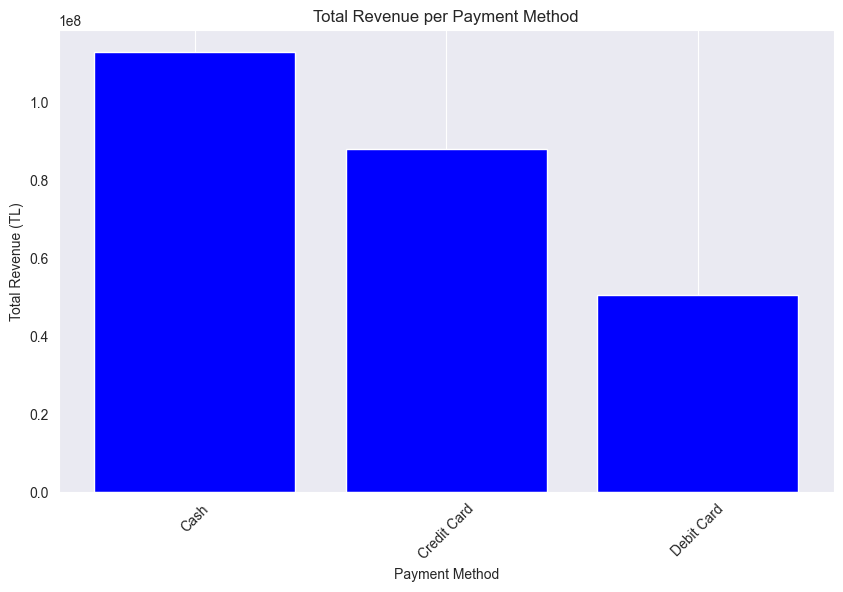

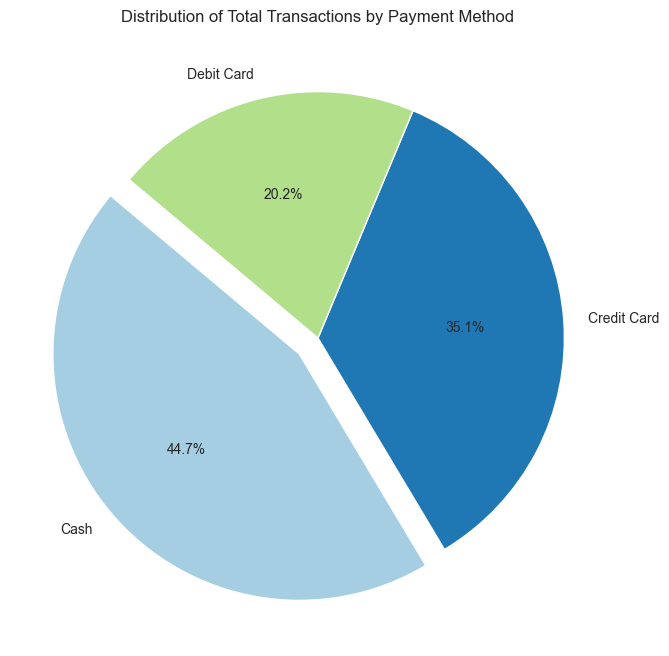

In [11]:
# Conversia rezultatelor interogării în Pandas DataFrame
df_query1 = query1.toPandas()

# Creăm un grafic de tip bar chart pentru venitul total per metodă de plată
plt.figure(figsize=(10, 6))
plt.bar(df_query1["payment_method"], df_query1["total_revenue"], color='blue')
plt.title("Total Revenue per Payment Method")
plt.xlabel("Payment Method")
plt.ylabel("Total Revenue (TL)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Pregătim datele pentru diagrama pie chart
labels = df_query1["payment_method"]
sizes = df_query1["total_transactions"]
colors = plt.cm.Paired.colors  # Folosim o paletă de culori prestabilită
explode = [0.1 if i == max(sizes) else 0 for i in sizes]  # Scoatem în evidență metoda de plată cu cele mai multe tranzacții

# Creăm diagrama pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title("Distribution of Total Transactions by Payment Method")
plt.show()

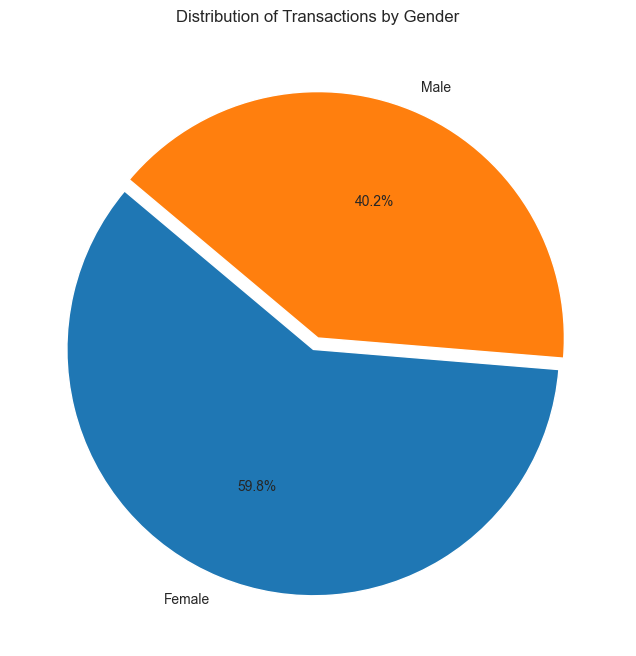

In [12]:
# Conversia în Pandas DataFrame
df_query2 = query2.toPandas()

# Pregătim datele pentru pie chart
labels = df_query2["gender"]
sizes = df_query2["count"]
colors = ['#1f77b4', '#ff7f0e']
explode = [0.05 if i == max(sizes) else 0 for i in sizes]

# Creăm diagrama pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode)
plt.title("Distribution of Transactions by Gender")
plt.show()


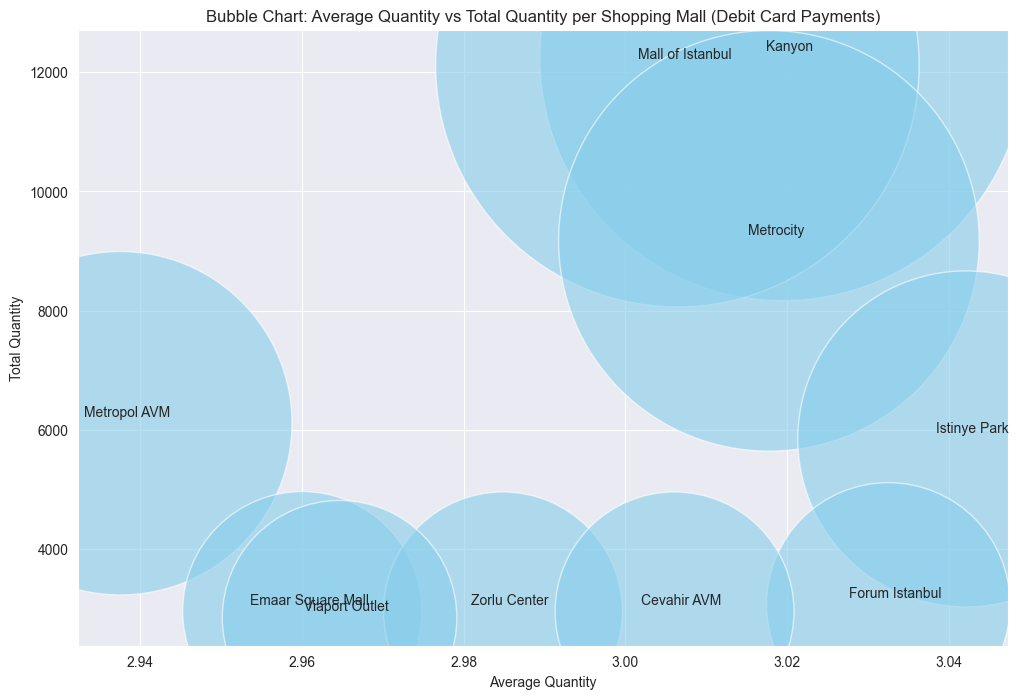

In [13]:
# Conversia rezultatelor interogării `query3` în Pandas DataFrame
df_query3 = query3.toPandas()

# Pregătim datele pentru bubble chart
x = df_query3["average_quantity"]
y = df_query3["total_quantity"]
sizes = df_query3["total_quantity"] * 10  # Dimensiunea bulelor este proporțională cu `total_quantity`
labels = df_query3["shopping_mall"]

# Creăm bubble chart
plt.figure(figsize=(12, 8))
bubble = plt.scatter(x, y, s=sizes, c='skyblue', alpha=0.6, edgecolors='w', linewidth=1)

# Adăugăm etichete pentru fiecare centru comercial
for i, label in enumerate(labels):
    plt.annotate(label, (x[i], y[i]), textcoords="offset points", xytext=(5,5), ha='center')

# Setăm titlul și etichetele axelor
plt.title("Bubble Chart: Average Quantity vs Total Quantity per Shopping Mall (Debit Card Payments)")
plt.xlabel("Average Quantity")
plt.ylabel("Total Quantity")
plt.grid(True)

# Afișăm figura
plt.show()


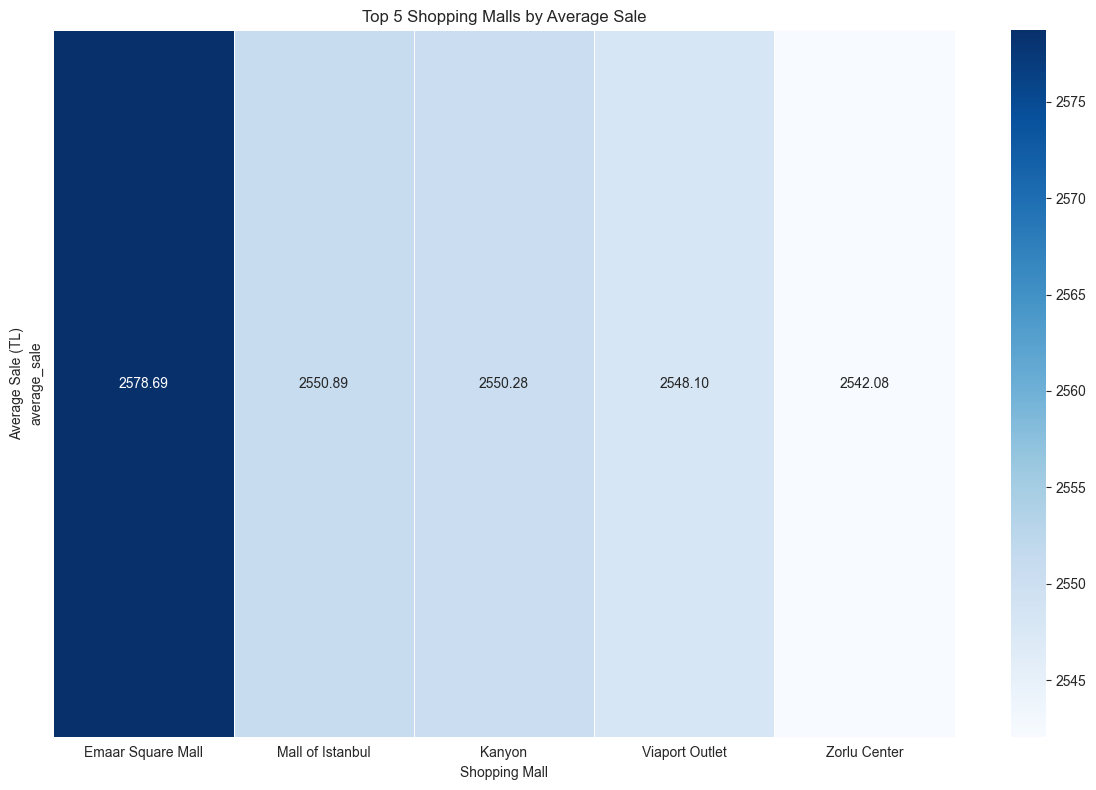

In [14]:
import seaborn as sns
# Conversia rezultatelor interogării `query4` în Pandas DataFrame
df_query4 = query4.toPandas()

# Pregătim datele pentru heatmap
# Creăm o matrice cu vânzările medii per centru comercial
heatmap_data = df_query4[['shopping_mall', 'average_sale']].set_index('shopping_mall')

# Creăm heatmap-ul
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data.T, annot=True, cmap='Blues', cbar=True, fmt='.2f', linewidths=0.5)

# Setăm titlul și etichetele axelor
plt.title("Top 5 Shopping Malls by Average Sale")
plt.xlabel("Shopping Mall")
plt.ylabel("Average Sale (TL)")

# Afișăm figura
plt.tight_layout()
plt.show()

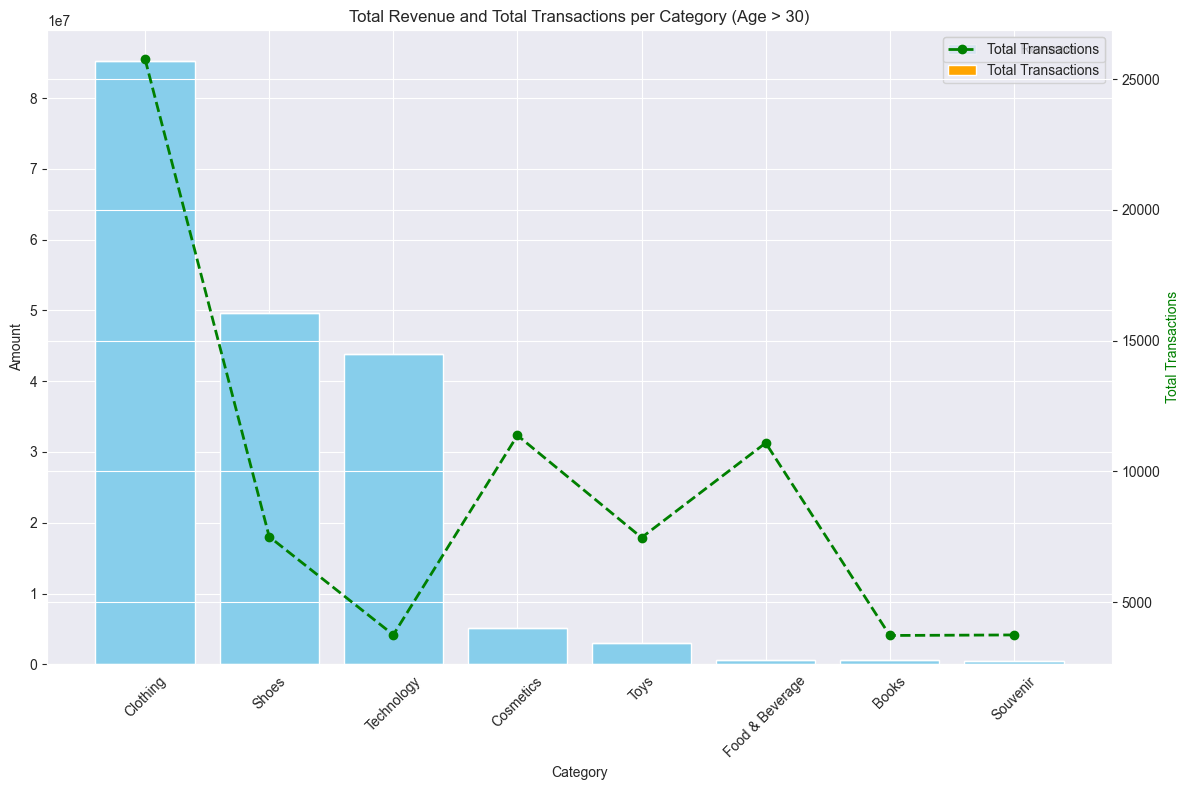

In [15]:
import matplotlib.pyplot as plt

# Conversia rezultatelor interogării `query5` în Pandas DataFrame
df_query5 = query5.toPandas()

# Pregătim datele pentru stacked bar chart
categories = df_query5['category']
total_revenue = df_query5['total_revenue']
total_transactions = df_query5['total_transactions']

# Creăm o figură și un ax secundar
fig, ax1 = plt.subplots(figsize=(12, 8))

# Creăm stacked bar chart pentru Total Revenue
ax1.bar(categories, total_revenue, label='Total Revenue', color='skyblue')
ax1.bar(categories, total_transactions, bottom=total_revenue, label='Total Transactions', color='orange')

# Setăm titlul și etichetele axelor
ax1.set_title("Total Revenue and Total Transactions per Category (Age > 30)")
ax1.set_xlabel("Category")
ax1.set_ylabel("Amount")
ax1.legend()

# Rotim etichetele pentru vizibilitate
plt.xticks(rotation=45)

# Creăm un ax secundar pentru a plota Total Transactions pe axa Y
ax2 = ax1.twinx()
ax2.plot(categories, total_transactions, label='Total Transactions', color='green', marker='o', linewidth=2, linestyle='--')
ax2.set_ylabel("Total Transactions", color='green')

# Adăugăm legendă pentru linia axei secundare
ax2.legend(loc='upper right')

# Afișăm graficul
plt.tight_layout()
plt.show()


#### 3.2   Dezvoltarea unor dashboard-uri interactive care să prezinte datele analizate. 

In [42]:
import dash
from dash import dcc, html
import dash_bootstrap_components as dbc
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd

# Creăm aplicația Dash
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Conversia rezultatelor interogărilor în Pandas DataFrame
df_query1 = query1.toPandas()  # Total Revenue per Payment Method
df_query2 = query2.toPandas()  # Total Transactions per Gender
df_query3 = query3.toPandas()  # Average Quantity and Total Quantity (Debit Card)
df_query4 = query4.toPandas()  # Top 5 Shopping Malls by Average Sale
df_query5 = query5.toPandas()  # Total Revenue and Total Transactions per Category (Age > 30)

# Grafic 1 - Bar chart Total Revenue per Payment Method
fig_revenue = px.bar(df_query1, x='payment_method', y='total_revenue',
                     title="Total Revenue per Payment Method",
                     labels={"total_revenue": "Total Revenue (TL)", "payment_method": "Payment Method"},
                     color='payment_method')

# Grafic 2 - Pie chart Total Transactions per Payment Method
fig_transactions = px.pie(df_query1, names='payment_method', values='total_transactions',
                          title="Distribution of Total Transactions by Payment Method",
                          color='payment_method', hole=0.3)

# Grafic 3 - Pie chart Total Transactions per Gender
fig_gender = px.pie(df_query2, names='gender', values='count',
                    title="Distribution of Transactions by Gender",
                    color='gender', hole=0.3)

# Grafic 4 - Bubble Chart Average Quantity vs Total Quantity per Shopping Mall
fig_quantity = px.scatter(df_query3, x='average_quantity', y='total_quantity', size='total_quantity',
                          color='shopping_mall', hover_name='shopping_mall', 
                          title="Average Quantity vs Total Quantity per Shopping Mall (Debit Card Payments)",
                          labels={"average_quantity": "Average Quantity", "total_quantity": "Total Quantity"})

# Grafic 5 - Heatmap pentru Top 5 Shopping Malls by Average Sale
heatmap_data = df_query4[['shopping_mall', 'average_sale']].set_index('shopping_mall')
fig_heatmap = go.Figure(data=go.Heatmap(z=heatmap_data.values, x=heatmap_data.columns, y=heatmap_data.index,
                                       colorscale='Blues', colorbar=dict(title="Amount (TL)")))

fig_heatmap.update_layout(title="Top 5 Shopping Malls by Average Sale", xaxis_title="Metrics", yaxis_title="Shopping Mall")

# Grafic 6 - Stacked Bar Chart for Total Revenue and Total Transactions per Category
fig_stack_bar = go.Figure()

# Adăugăm barurile pentru Total Revenue
fig_stack_bar.add_trace(go.Bar(x=df_query5['category'], y=df_query5['total_revenue'], name='Total Revenue', marker_color='skyblue'))

# Adăugăm linia pentru tranzacții
fig_stack_bar.add_trace(go.Scatter(x=df_query5['category'], y=df_query5['total_transactions'], mode='lines+markers', name='Total Transactions Line', 
                                   line=dict(color='green', width=2, dash='dash'), marker=dict(color='green', size=6)))

fig_stack_bar.update_layout(barmode='stack', title="Total Revenue and Total Transactions per Category (Age > 30)",
                            xaxis_title="Category", yaxis_title="Amount", showlegend=True)

app.layout = html.Div(
    style={
        'backgroundColor': '#2E2E2E',
        'minHeight': '100vh',  # Setează înălțimea minimă la înălțimea ecranului
        'overflow': 'hidden',  # Elimină scroll-ul
        'padding': '0px',  # Elimină orice padding
        'margin': '0px',   # Elimină orice margine
    },
    children=[
        html.H1(
            "Interactive Dashboard for Data Analysis",
            style={'text-align': 'center', 'color': 'white'}
        ),

        # Row pentru cele 5 grafice
        dbc.Row(
            [
                dbc.Col(dcc.Graph(figure=fig_revenue, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
                dbc.Col(dcc.Graph(figure=fig_transactions, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
                dbc.Col(dcc.Graph(figure=fig_gender, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
            ],
            style={'margin': '0px'}
        ),

        # Al doilea rând de grafice
        dbc.Row(
            [
                dbc.Col(dcc.Graph(figure=fig_quantity, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
                dbc.Col(dcc.Graph(figure=fig_heatmap, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
                dbc.Col(dcc.Graph(figure=fig_stack_bar, config={'displayModeBar': False}), width=4, style={'padding': '10px'}),
            ],
            style={'margin': '0px'}
        )
    ]
)
# Rulăm aplicația
if __name__ == '__main__':
    app.run_server(debug=True, use_reloader=False)